In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090b_hw1.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## Homework 1: Clustering & Hierarchical Bayesian Models



**Harvard University**<br/>
**Spring 2025**<br/>
**Instructors**: Pavlos Protopapas & Natesh Pillai


<hr style="height:2pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

## Notebook Contents
<a id="contents"></a>
- [**Part 0: K-means Clustering of Animal Traits**](#part0)
- **Bayesian Logistic Regression**
- [**Part 1: Varying-Intercept Model (Simulated Response Variable)**](#part1)
- [**Part 2: Varying-Intercept Model (Real Data)**](#part2)
- [**Part 3: Varying-Coefficients Model**](#part3)
- [**Part 4: Prediction & Model Selection**](#part4)

In [3]:
# Imports for Part 0
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# You can decide what to import from the preprocessing module
#from sklearn.preprocessing import ...
from sklearn.preprocessing import StandardScaler
# import sillhouette score
from sklearn.metrics import silhouette_score

In [4]:
# measure notebook runtime
time_start = time.time()

<a id="part0"></a>

### <div class='exercise'>Part 0: K-means Clustering of Animal Traits</div> 
As a warm-up, we'll perform K-means clustering on a dataset of animal characteristics before moving on to our main Bayesian analysis.

[Return to contents](#contents)

<!-- BEGIN QUESTION -->
<div class='exercise'><b>Q0.1 - Data Preprocessing</b></div>

The file `zoo.csv` contains information about 100 different animals.

Load the data into a Pandas DataFrame and inspect the features. You will need to decide which columns it makes sense to include as input to the K-means clustering algorithm and what preprocessing you deem necessary. Store the processed features in a matrix `X`.

**Note:** You must justify your preprocessing decisions based on the nature of the features and your clustering objectives. This also applies to *negative* decisions (e.g., choices to *not* perform a generally standard type of preprocessing). 

In [5]:
# your code here

zoo_data = pd.read_csv('data/zoo.csv')
zoo_data.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [6]:
# preprocessing

# based on substantive knowledge, some of the variables are redundant
X = zoo_data.drop(columns=['hair', 'feathers', 'eggs', 'milk', 'fins', 'animal_name'])

# One hot encode class type
X = pd.get_dummies(X, columns=['class_type'], dtype=int)
X.head()

,airborne,aquatic,predator,toothed,backbone,breathes,venomous,legs,tail,domestic,catsize,class_type_1,class_type_2,class_type_3,class_type_4,class_type_5,class_type_6,class_type_7
0,0,0,1,1,1,1,0,4,0,0,1,1,0,0,0,0,0,0
1,0,0,0,1,1,1,0,4,1,0,1,1,0,0,0,0,0,0
2,0,1,1,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0
3,0,0,1,1,1,1,0,4,0,0,1,1,0,0,0,0,0,0
4,0,0,1,1,1,1,0,4,1,0,1,1,0,0,0,0,0,0


I chose not to look at correlations between these variables because class_type (e.g. mammal, fish, reptile, etc.) explains more than traits that are correlated with class (e.g. hair, feathers, eggs.) To avoid redundancy and collinearity, I chose to drop hair, feathers, eggs, milk, and fins from X. Additionally, animal name is not important for clustering. Then, to preserve information from class_type, I one hot encoded class_type. I chose not to do this for legs because legs is a discrete numerical variable. Finally, scaling the data is not necessary because each feature aside from legs is a binary categorical variable. 


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q0.2 - PCA Visualization</b></div>
Before we begin clustering, we should attempt to visualize the data.

Create a 2D scatter plot of the data projected onto the first two principle components. Be sure to also report the variance explained by these components.

Based on your visualization, discuss whether you see evidence of natural clusters in the data.

**Hint:** There is a PCA projection plot in the penguin example at the end of the lab 1 notebook.

Text(0.5, 1.0, 'Data Projected Onto the First Two Principal Components')

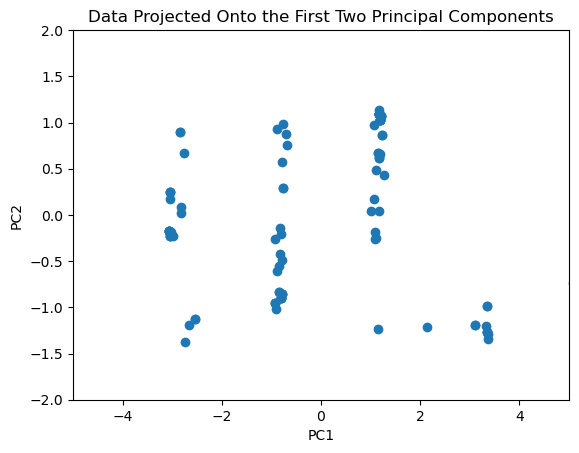

In [7]:
# perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlim(-5,5)
plt.ylim(-2,2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Data Projected Onto the First Two Principal Components')

In [8]:
# output loadings
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=X.columns)
loadings

,PC1,PC2
airborne,0.011784,-0.282228
aquatic,-0.090446,-0.118931
predator,-0.028793,0.063282
toothed,-0.049444,0.481405
backbone,-0.083153,0.288791
breathes,0.077419,0.127793
venomous,0.003145,-0.070296
legs,0.975565,0.019689
tail,-0.077946,0.225932
domestic,0.013110,0.046750


Text(0, 0.5, 'Cumulative Explained Variance')

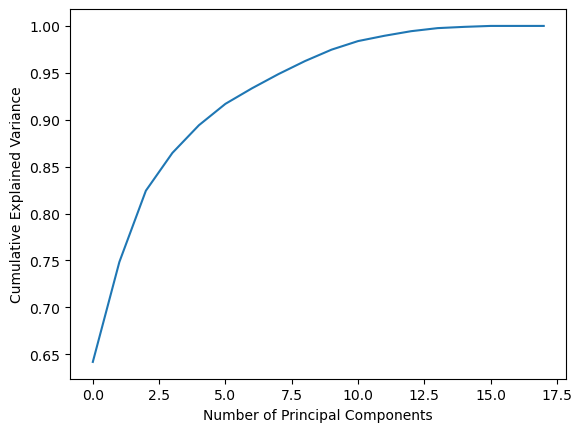

In [9]:
# variance explained for all components
pca = PCA()
X_pca = pca.fit_transform(X)

explained_variance = pca.explained_variance_ratio_
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')

In [10]:
explained_variance[:2]

array([0.64190898, 0.10643702])

There is clear evidence of natural clustering within the data based on the scatterplot. ```legs``` strongly contributes to the first PC. I noted that I did not scale this variable, which may have caused this effect due to higher magnitude. However, I went back and scaled ```legs``` to standardized values, and it still contributed a coefficient value greater than 0.8 for PC1. Given that some of the clustering effect was visually lost after scaling the only numeric variable, I chose to stick with my original decision to not scale the data.

The explained variance ratio of these first two components is about 0.64 and 0.11, respectively.


<!-- BEGIN QUESTION -->
<div class='exercise'><b>Q0.3 - Determining Optimal $k$</b></div>
Implement and visualize two different methods for determining the optimal number of clusters:

1. Plot the inertia vs $k$ for $k \in \{2,3,\dots,20\}$
2. Plot the average silhouette score vs $k$ for the same range

Choose and justify your optimal k based on these metrics. Discuss any differences between what the metrics suggest and whether one seems more reliable for this dataset.

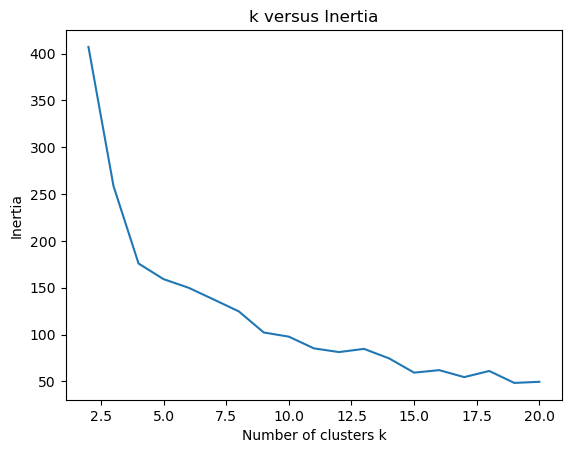

In [11]:
import warnings

# Ignore warnings in the following indented code

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # iterate over k [2,20]

    inertia_values = []
    for k in range(2, 21):
        km = KMeans(n_clusters=k)
        km.fit(X)
        inertia_values.append(km.inertia_)

    plt.plot(range(2, 21), inertia_values)
    plt.xlabel('Number of clusters k')
    plt.ylabel('Inertia')
    plt.title('k versus Inertia')
    plt.show()



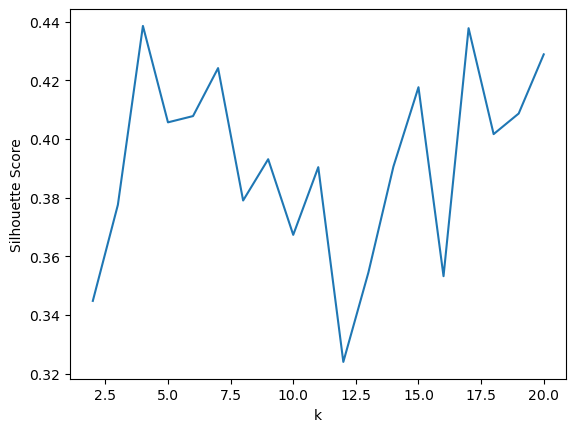

In [12]:
# do the same for sillhouette score
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    silhouette_scores = []
    for k in range(2, 21):
        km = KMeans(n_clusters=k)
        km.fit(X)
        silhouette_scores.append(silhouette_score(X, km.labels_))

    plt.plot(range(2, 21), silhouette_scores)
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')

Here, both metrics suggest a k of 5. This is because the inertia in this case shows a clear 'elbow' that decreases at a decreasing rate when k increases after 5. In addition, the Sillhouette score indicates that clusters are the most well-separated at number of clusters k = 5 and 20. In order to keep the model less complex and more generalizable, choosing a k of 5 is best here.


<!-- BEGIN QUESTION -->
<div class='exercise'><b>Q0.4 - Cluster Analysis</b></div>

Using the results of fitting K-means with your choice of optimal $k$, create a visualization showing:
   - Your datapoints in the 2D PCA space
   - Points colored by cluster assignment
   - Each `animal_name` annotated on the plot near its corresponding point 

Finally, interpret your results:
   - How well-separated are your clusters?
   - Do the clusters align with biological classifications?
   - Do any points seem to have been assigned to the wrong cluster? You may not be able to tell from your plot alone and so you should investigate this issue using one of the metrics discussed in class.

c:\Users\khcod\micromamba\envs\cs109a\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


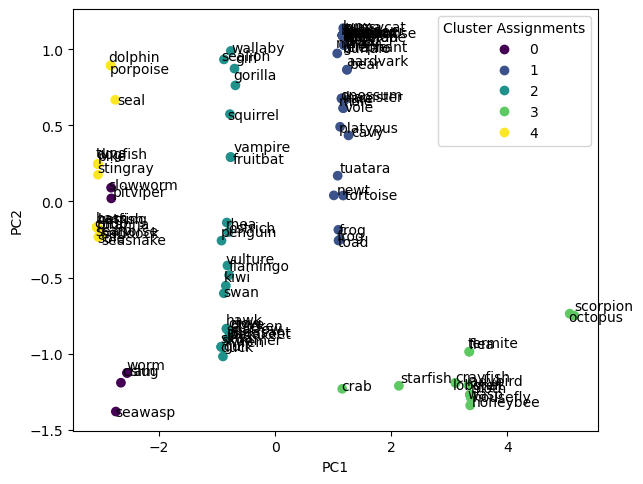

In [13]:
# fit k mean with k =5
km = KMeans(n_clusters=5)
km.fit(X)

# plot the first two principal components with colors by labels
plt.figsize = (20, 20)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')

# add legend for color labels
handles, labels = scatter.legend_elements()
plt.legend(handles, labels, title="Cluster Assignments")

# annotate animal_name for each data point
for i, txt in enumerate(zoo_data['animal_name']):
    jitter_x = np.random.uniform(-0.05, 0.05)
    jitter_y = np.random.uniform(-0.05, 0.05)

    plt.annotate(txt, (X_pca[i, 0] + jitter_x, X_pca[i, 1] + jitter_y))

plt.rc('font', size=5)
plt.tight_layout()

The clusters seem very well-separated along the axes of PC1 and PC2. However, the cluster assignments are imbalanced as very few animals are in cluster 4, shown in yellow. The clusters seem to mostly group animals together appropriately. For example, cluster 4 consists of aquatic bottom dwellers. That being said, PC1 highlights the possible overreliance on variance explained by legs, as scorpion and octopus, two drastically different animals, are in the same cluster and practically on top of each other based on PC1 and PC2. As follows, few points are assigned to the "wrong" cluster based on the data that kmeans read, but the algorithm may be weighing the ```legs``` variable too much.



In [14]:
# Additional imports for Parts 1-4
%pip install arviz
%pip install pymc
import arviz as az
import pymc as pm
from scipy.special import expit

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


## Hierarchical Bayesian Models

## Dataset Information

### Contraceptive Usage by Bangladeshi Women

For this assignment, you are provided with datasets `train.csv` and `test.csv` which contain details of contraceptive usage among 1,934 Bangladeshi women.

There are four attributes for each woman along with a response variable, `contraceptive_use`, indicating if she uses contraceptives. The four attributes include:

* `district`: code identifying the district in which the woman lives (60 districts in total)
* `urban`: type of region of residence (binary)
* `living.children`: number of living children
* `age-mean`: age of the woman (in years, centered around mean)

The task is to build a classification model that can predict if a given woman uses contraceptives.

The following cell will load and inspect the train and test datasets.

TRAINING DATA INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   district           967 non-null    int64  
 1   urban              967 non-null    int64  
 2   living.children    967 non-null    int64  
 3   age_mean           967 non-null    float64
 4   contraceptive_use  967 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 37.9 KB

TEST DATA INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   district           967 non-null    int64  
 1   urban              967 non-null    int64  
 2   living.children    967 non-null    int64  
 3   age_mean           967 non-null    float64
 4   contraceptive_use  967 non-null    int64  
dtypes: float64(1), int64(4)
m

,district,urban,living.children,age_mean,contraceptive_use
0,35,0,4,2.4400,0
1,22,0,2,-1.5599,1
2,29,0,2,-8.5599,1


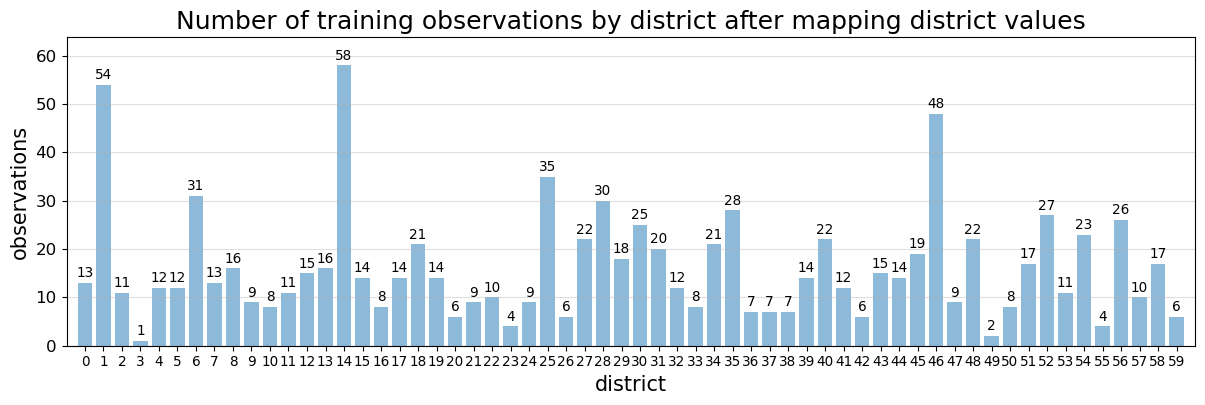

In [15]:
# loading and inspecting the data
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

# print dataset summary info for ease of reference
print("TRAINING DATA INFO:\n")
df_train.info()
print("\nTEST DATA INFO:\n")
df_test.info()
print("\nTRAINING DATA SUMMARY STATS:\n")
print(df_train.describe())
print("\nTRAINING DATA FIRST ROWS OF DATA:")
display(df_train.head(3))
print()

# And plot observation counts by district also just for reference
def plot_value_counts(value_counts, var_name, font_perc):
    """Generates barplot from pandas value_counts series"""
    fig, ax = plt.subplots(figsize=(12, 4))

    max_y = max(value_counts.values)
    n_cats = len(value_counts)

    ax.bar(range(n_cats), value_counts.values, alpha=0.5)

    for x, y in enumerate(value_counts):
        ax.text(
            x, y+max_y*.02,
            "{:,}".format(y),
            color="k",
            fontsize=14*font_perc,
            horizontalalignment="center"
        ) 

    ax.set_title(
        "Number of training observations by {} after mapping district values".format(
            var_name
        ),
        fontsize=18
    )
    ax.set_xlabel("{}".format(var_name), fontsize=15)
    ax.set_ylabel("observations", fontsize=15)
    ax.set_xticks(range(n_cats))
    ax.set_xticklabels(value_counts.index)
    ax.tick_params("x", labelsize=14*font_perc)
    ax.tick_params("y", labelsize=12)
    ax.set_ylim(top=max_y+(max_y*.1))

    ax.grid(":", axis="y", alpha=0.4)
    ax.margins(x=.01)
    plt.tight_layout()
    plt.show();

# plot and print summary of resulting district values
dist_counts = df_train["district"].value_counts().sort_index()

plot_value_counts(dist_counts, "district", .7)



## Bayesian Logistic Regression with Varying-Intercept Description


The first model we'd like to fit to the contraceptives data will be a **varying-intercept logistic regression** model, where the model's intercept varies by district.

Prior distributions:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_1 &\sim N(0,10000) 
\\ \\ 
\beta_2 &\sim N(0,10000)
\\ \\ 
\beta_3 &\sim N(0,10000)
\\ \\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} & \sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}
\\ \\
\end{split}
$$

Where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

**PLEASE NOTE:** The $\text{Gamma}$ distribution cited above, uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate.  

<a id="part1"></a>

### <div class='exercise'>Part 1: Varying-Intercept Model (Simulated Response Variable)</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.1 - Simulate Response</b></div>

To verify that PyMC can indeed recover the hidden parameter values, we'll simulate values of the response variable, `contraceptive_use`, for observations in the training set using the 4 predictors and *hard-coded model parameters of our choosing*. Then, using this simulated data, we'll check if PyMC can get back the parameter values that we hard-coded. If it does, we'll have some reason to believe that it can recover the hidden parameter values that generated the *real* data.

**Note: Synthetic response values generated using the parameters below will only be used in question 1.1 - 1.4**.

Generate $Y$ using the training data and the following hard-coded values:

$$
\begin{split}
\mu_0 &= 0.5
\\ \\
\sigma^2_0 &= 0.3
\\ \\
\beta_{0j} &\sim N(\mu_0,\sigma_0^2) \; \text{for all sixty districts}
\\ \\
\beta_1 &= 1
\\ \\ 
\beta_2 &= -0.5
\\ \\
\beta_3 &= -0.3
\\ \\
\end{split}
$$

Save your simulated values in a numpy array called `simulated_Y`.

**Verify that these parameters generate data in which an average of 48% to 50% of subjects use contraceptives.**

In [16]:
# set seed for consistency across runs

#mu_prior = 0.5
# sigma_prior = np.sqrt(0.3)

# create list of 60 beta_0 values
# beta_0_list = [np.random.normal(mu_prior, sigma_prior) for _ in range(60)]
# beta_1 = 1
# beta_2 = -0.5
# beta_3 = -0.3

# iterate over each district j
# Y_ij = pd.DataFrame()
# for d in range(60):
#     district_data = df_train[df_train['district'] == d]
#     logit = beta_0_list[d] + beta_1 * district_data['urban'] + beta_2 * district_data['living.children'] + beta_3 * district_data['age_mean']
#     Y_ij = pd.concat([Y_ij, pd.DataFrame({'district': d+1, 'logit': logit})]) #add 1 to match python indexing

# calculate simulated Y from above formula with bernoulli for Bayes log reg
#simulated_Y = np.random.binomial(1, expit(Y_ij['logit']))

In [17]:
np.random.seed(109)

mu_0_true = 0.5
sigma_0_true = np.sqrt(0.3)  # sigma^2_0 = 0.3
beta1_true = 1.0
beta2_true = -0.5
beta3_true = -0.3
n_districts = 60

# Number of total obs
n_obs = len(df_train)

# idx for each intercept
district_idx, districts = pd.factorize(df_train['district'])
beta0_true = np.random.normal(mu_0_true, sigma_0_true, size=n_districts)

# Random predictors
X1 = np.random.normal(0, 1, size=n_obs)
X2 = np.random.normal(2, 1, size=n_obs)
X3 = np.random.normal(-1, 1, size=n_obs)

# Total linear predicto
eta = beta0_true[district_idx] + beta1_true*X1 + beta2_true*X2 + beta3_true*X3

# Convert linear predictor to probability
p = 1 / (1 + np.exp(-eta))

# Generate the synthetic binary outcomes
simulated_Y = np.random.binomial(n=1, p=p, size=n_obs)

In [18]:
# Add as col to training data
df_train['simulated_Y'] = simulated_Y
print(f"Average contraceptive use in simulated data: {simulated_Y.mean():.3f}")

Average contraceptive use in simulated data: 0.495


In [19]:
grader.check("q#1.1")

q#1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.2 - Fit Varying-Intercept Model (Simulated Data)</b></div>

Create and fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested by any warnings from PyMC.

In [20]:
# Add the labels to the DataFrame representing each district
df_train['district_idx'] = district_idx
df_train.head()

,district,urban,living.children,age_mean,contraceptive_use,simulated_Y,district_idx
0,35,0,4,2.4400,0,0,0
1,22,0,2,-1.5599,1,1,1
2,29,0,2,-8.5599,1,1,2
3,5,0,3,-4.5599,1,1,3
4,34,1,4,8.4400,0,1,4


In [21]:
# attempt 1

# # parameter values from above
# mu_0_true = 0.5
# sigma_0_true = np.sqrt(0.3)  # sigma^2_0 = 0.3
# beta1_true = 1.0
# beta2_true = -0.5
# beta3_true = -0.3

# # Assume we have 60 districts:
# n_districts = 60

# # For demonstration, let's say you already have a training dataset with:
# #   district indices for each observation (dist_idx)
# #   three predictors: X1, X2, X3 
# # To keep this example self-contained, let’s just create some random design:

# # Number of total observations (example: 600 individuals split over 60 districts)
# n_obs = len(df_train)

# # Fake district index for each individual (0 to 59)
# dist_idx = np.random.randint(0, n_districts, size=n_obs)

# # Draw the district-specific intercepts
# beta0_true = np.random.normal(mu_0_true, sigma_0_true, size=n_districts)

# # Create random predictor values; shape = (n_obs,)
# # (you would normally extract these from your real training data.)
# X1 = np.random.normal(0, 1, size=n_obs)
# X2 = np.random.normal(2, 1, size=n_obs)
# X3 = np.random.normal(-1, 1, size=n_obs)

# # Now form the linear predictor: eta_i = beta0_true[district_i] + beta1_true*X1 + ...
# eta = beta0_true[dist_idx] + beta1_true*X1 + beta2_true*X2 + beta3_true*X3

# # Convert linear predictor to probability via the logistic function
# p = 1 / (1 + np.exp(-eta))

# # Generate the synthetic binary outcomes
# simulated_Y = np.random.binomial(n=1, p=p, size=n_obs)


In [31]:
with pm.Model() as sim_model:
    
    # Hyperpriors to be used for creating varying-intercepts
    mu_0 = pm.Normal('mu_0', mu=0., sigma=1.0)  
    sigma_0 = pm.HalfNormal('sigma_0', sigma=1.0)  
    tau_0 = pm.Deterministic('tau_0', sigma_0**-2)
    
    # create varying intercepts with shape num districts
    beta0 = pm.Normal('beta0', mu=mu_0, sigma=sigma_0, shape=60)
    
    # create slopes (not varying for Q1)
    beta1 = pm.Normal('beta1', mu=0., sigma=1.0)
    beta2 = pm.Normal('beta2', mu=0., sigma=1.0)
    beta3 = pm.Normal('beta3', mu=0., sigma=1.0)
    
    # plug into logit and use synthetic data (from above)
    # .Deterministic saves the probability for later use
    p = pm.Deterministic('p', pm.math.sigmoid(beta0[district_idx] + beta1*X1 + beta2*X2 + beta3*X3))
    y = pm.Bernoulli('contraceptive_use', p, observed=simulated_Y)
    
    # reduce draw and tune size for runtime
    sim_trace = pm.sample(100, tune=100, target_accept=0.9, random_seed=42)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, sigma_0, beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 2618 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.3 - Convergence Diagnostics</b></div>

Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \frac{1}{\sigma^2_0}\text{ (a.k.a., }\tau_0\text{)}, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged? Explain your reasoning.


**Hint:** Use the Arviz `plot_trace()` function

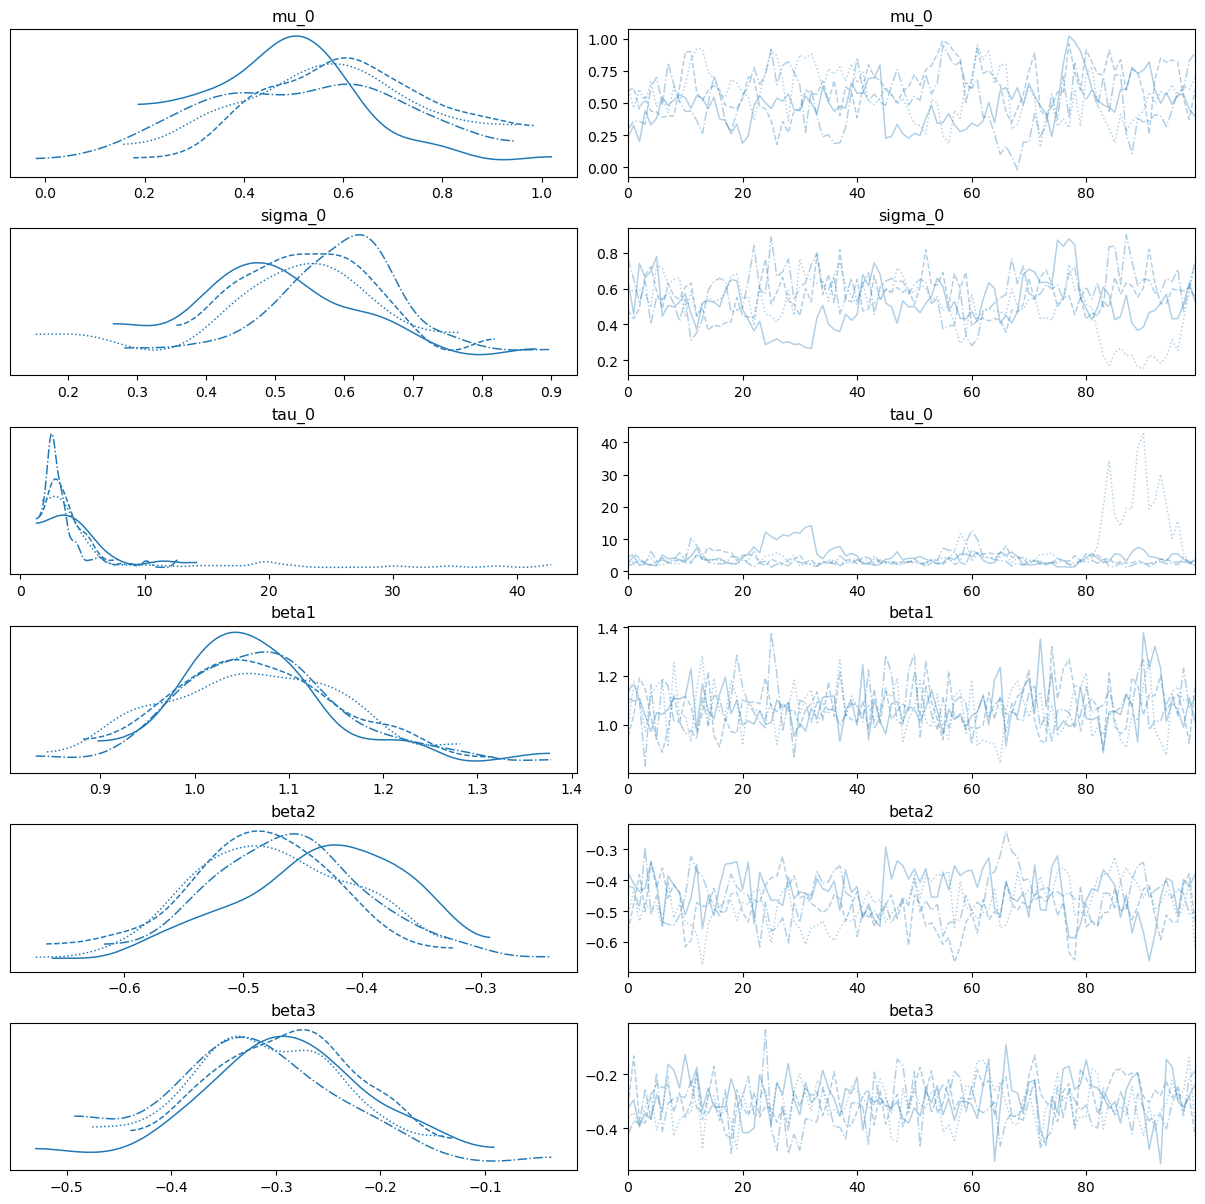

In [32]:
az.plot_trace(sim_trace, var_names=['mu_0', 'sigma_0', 'tau_0', 'beta1', 'beta2', 'beta3']) # NOTE: ADD FOLLOWING AS ARG var_names=['mu_0', 'sigma_0', 'beta_1', 'beta_2', 'beta_3', 'tau_0', 'beta0', 'beta1', 'beta2', 'beta3', 'p']
plt.tight_layout()

In [33]:
# results for all variables besides intercepts
results = pm.summary(sim_trace, var_names=['mu_0', 'sigma_0', 'tau_0', 'beta1', 'beta2', 'beta3'])
results[:10] 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_0,0.548,0.194,0.226,0.923,0.023,0.019,79.0,158.0,1.09
sigma_0,0.542,0.133,0.226,0.767,0.022,0.015,43.0,30.0,1.09
tau_0,4.502,4.436,1.233,10.286,0.921,0.660,43.0,30.0,1.09
beta1,1.069,0.092,0.906,1.235,0.005,0.003,399.0,300.0,1.02
beta2,-0.465,0.072,-0.587,-0.322,0.009,0.007,58.0,215.0,1.09
beta3,-0.304,0.079,-0.440,-0.143,0.005,0.003,248.0,295.0,1.02


The chains look well-mixed in the trace plots on the right with few trends. I chose to vastly reduce the number of tune and draw iterations by orders of magnitude lower than the number in lab in order to reduce runtime, so some noisy trends are more evident than they would hypothetically be normally. The left side shows that the posterior distributions are similar for the two chains for each respective parameter. 


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.4 - Inspecting Posteriors</b></div>

Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions?

**Hint: The `az.plot_posterior()` function might be helpful here.**

c:\Users\khcod\micromamba\envs\cs109a\Lib\site-packages\arviz\plots\plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (60) in plot_posterior, generating only 40 plots
  warnings.warn(


array([<Axes: title={'center': 'beta0\n9'}>,
       <Axes: title={'center': 'beta0\n19'}>,
       <Axes: title={'center': 'beta0\n29'}>,
       <Axes: title={'center': 'beta0\n39'}>], dtype=object)

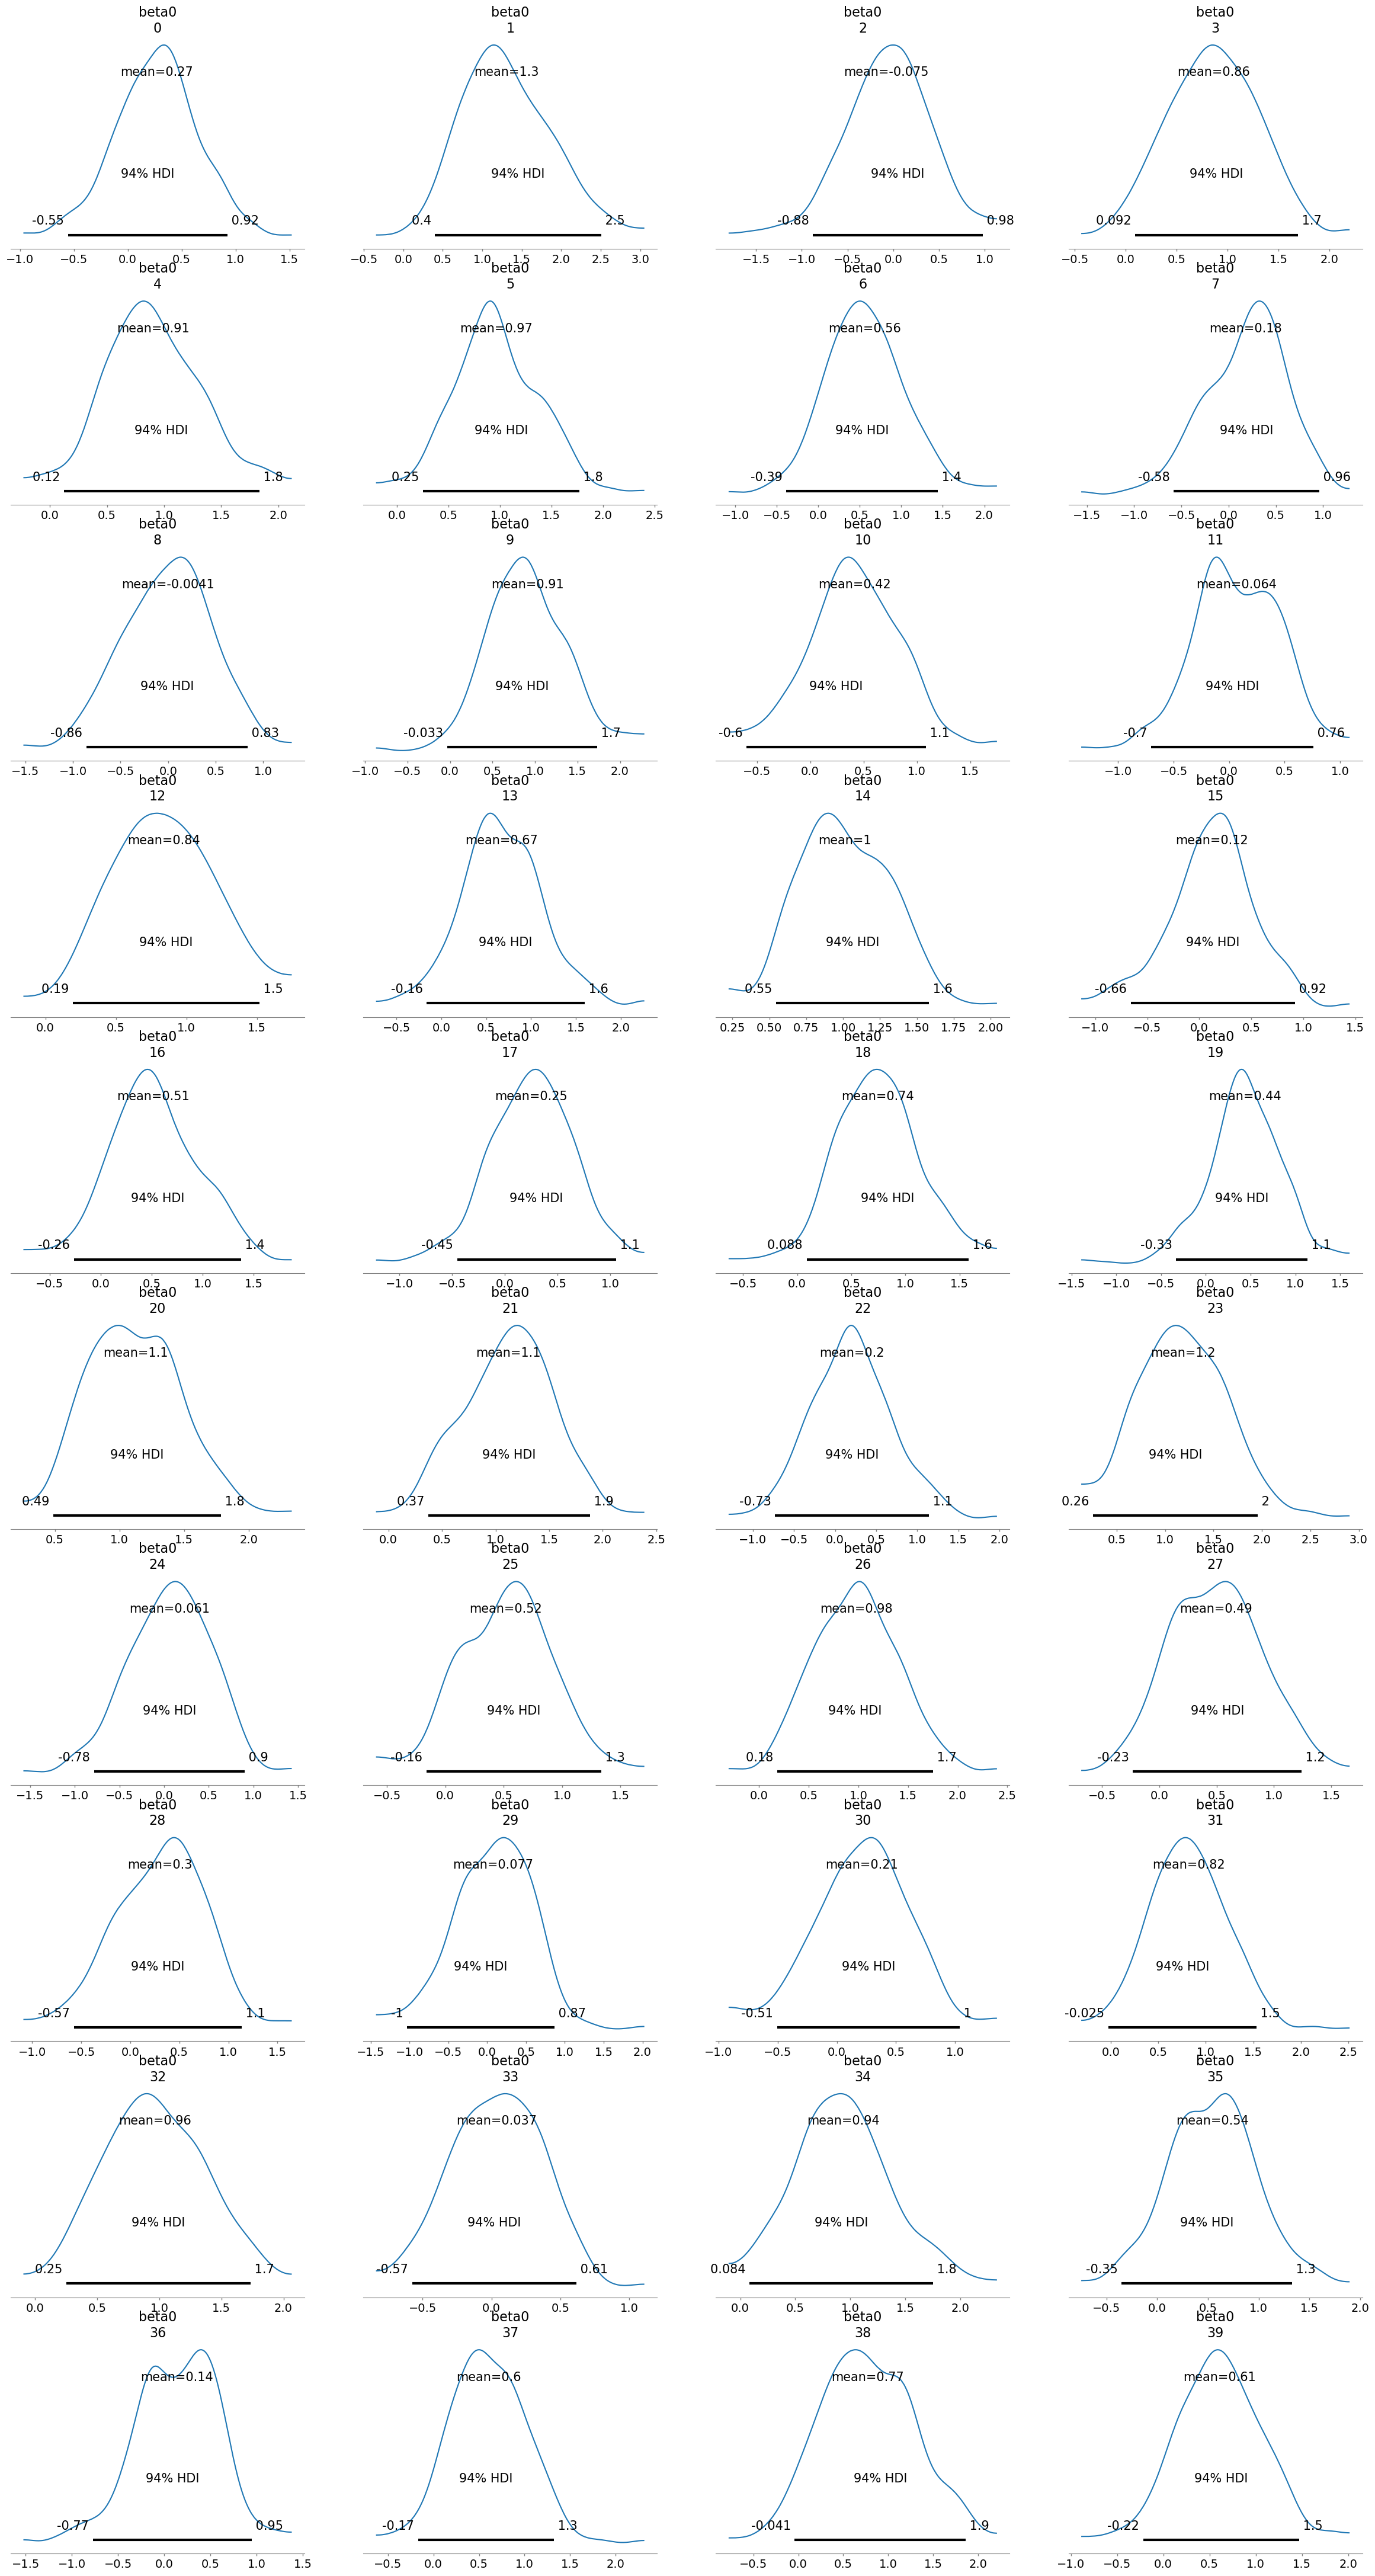

In [39]:
# plot just choice districts for intercepts

choice_districts = [9, 19, 29, 39]
az.plot_posterior(sim_trace, var_names=['beta0'], round_to=2).flatten()[choice_districts]

Yes, the actual parameters are contained within the posterior distributions. For the choice districts $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$ that are plotted, the original mean intercept value of 0.5 is within the 94% HDI while the other predefined parameters $\beta_1$, $\beta_2$, and $\beta_3$ are only contained in some of the posterior distributions due to the varying intercepts.


<a id="part2"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

### <div class='exercise'>Part 2: Varying-Intercept Model (Real Data)</div> 

[Return to contents](#contents)


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.1 - Fit Varying-Intercept Model (Real Data)</b></div>

Now we'll fit our model to the *actual* data. Construct and fit the varying-intercept model to the real training data.

In [ ]:
# get index for each district 
# district_idx, districts = pd.factorize(df_train['district'])
# n_districts = len(districts)

# Explanatory variables for model (actual data)
X1 = df_train['urban'].values
X2 = df_train['living.children'].values
X3 = df_train['age_mean'].values

with pm.Model() as actual_model:

    mu_0 = pm.Normal('mu_0', mu=0., sigma=1.0) 
    sigma_0 = pm.HalfNormal('sigma_0', sigma=1.0)  
    beta0 = pm.Normal('beta0', mu=mu_0, sigma=sigma_0, shape=n_districts)
    
    # Same as above not varying
    beta1 = pm.Normal('beta1', mu=0., sigma=1.0)
    beta2 = pm.Normal('beta2', mu=0., sigma=1.0)
    beta3 = pm.Normal('beta3', mu=0., sigma=1.0)
    
    # Linear predictor for each observation, then logit, then likelihood as above
    eta = beta0[district_idx] + beta1*X1 + beta2*X2 + beta3*X3 #use already defined district idx
    p = pm.Deterministic('p', pm.math.sigmoid(eta))
    y = pm.Bernoulli('contraceptive_use', p, observed=df_train['contraceptive_use'])
    
    # Sample from the posterior
    trace = pm.sample(50, tune=50, target_accept=0.9, random_seed=42)

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, sigma_0, beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 50 tune and 50 draw iterations (200 + 200 draws total) took 2563 seconds.
The number of samples is too small to check convergence reliably.


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2 - Convergence Diagnostics</b></div>

Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

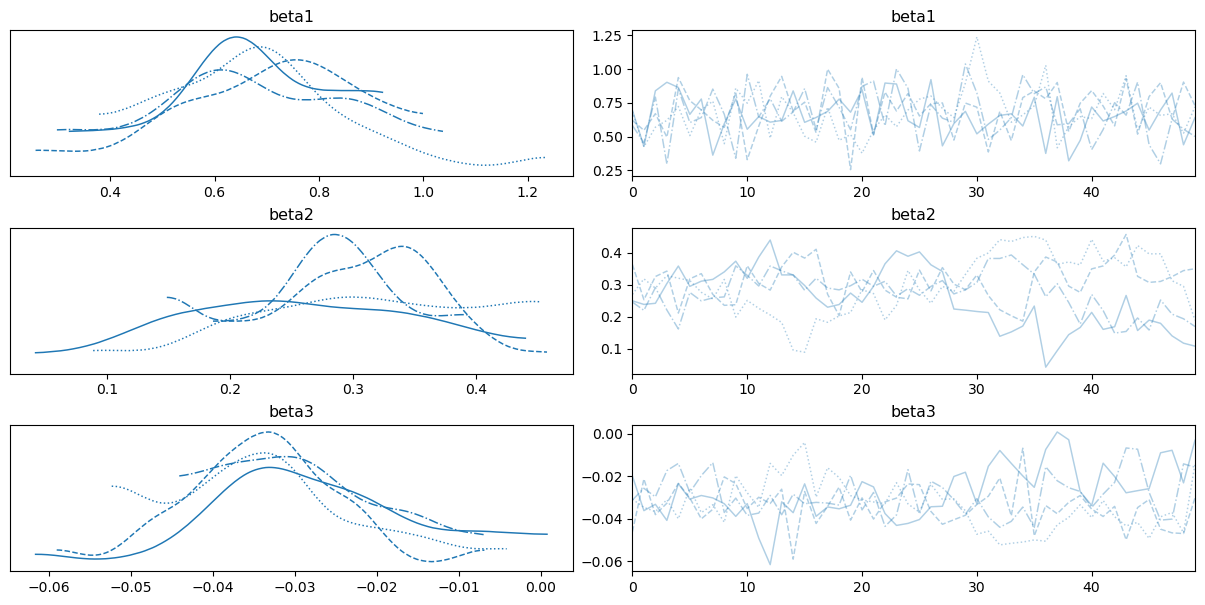

In [43]:
# use az.plot_trace as above
az.plot_trace(trace, var_names=['beta1', 'beta2', 'beta3'])
plt.tight_layout()

In [44]:
# output results and look for district with highest intercept value
results = pm.summary(trace, var_names=['mu_0', 'sigma_0', 'beta0','beta1', 'beta2', 'beta3'])
results[results.index.str.contains('beta0')].sort_values('mean', ascending=False).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0[15],-0.571,0.427,-1.239,0.323,0.055,0.039,68.0,124.0,1.05
beta0[4],-0.753,0.413,-1.488,0.094,0.041,0.031,101.0,110.0,1.04
beta0[12],-0.818,0.347,-1.391,-0.129,0.050,0.036,49.0,201.0,1.06
beta0[35],-0.855,0.491,-1.726,-0.038,0.085,0.061,33.0,30.0,1.08
beta0[5],-0.860,0.478,-1.782,-0.047,0.054,0.039,106.0,156.0,1.06


The density plots for $\beta_2$ specifically seem to vary significantly among the four chains. Additionally, the trace plots show clear signs of dependence within the Markov Chains. That being said, the trace plots for $\beta_1$ and $\beta_3$ appear more stochastic. The r-hats are close to 1, also indicating convergence and well-mixed chains.


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.3 - Districts with Highest & Lowest Rates of Contraceptive Usage</b></div>

Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest? Explain how you arrived at these conclusions, interpreting any numerical values that played a role in your reasoning.

In [ ]:
# Output district with highest and lowest intercept value
beta0_means = trace.posterior['beta0'].mean(axis=(0, 1)).values

highest_intercept_idx = np.argmax(beta0_means)
lowest_intercept_idx = np.argmin(beta0_means)

print(f"District with highest base rate of contraceptive usage: {highest_intercept_idx}")
print(f"Highest intercept value: {beta0_means[highest_intercept_idx]:.2f}")

print(f"District with lowest base rate of contraceptive usage: {lowest_intercept_idx}")
print(f"Lowest intercept value: {beta0_means[lowest_intercept_idx]:.2f}")

District with highest base rate of contraceptive usage: 15
Highest intercept value: -0.57
District with lowest base rate of contraceptive usage: 50
Lowest intercept value: -2.08


the log-odds, monotonic with probability $p = \frac{1}{1 + \exp(-(-(\text{intercept value})))}$, can be converted to 0.36 and 0.11 base rates of contraceptive usage for the district with the highest and lowest base rates, respectively. The intercept value output above represents the mean log-odds of contraceptive usage for the posterior distribution of the above varying-intercept model.


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.4 - Varying Intercept? Conclusions from Posterior Samples</b></div>

What are the posterior means of $\mu_0$ and $\sigma_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts? Explain why or why not.


**Hint:** Both ArviZ's `plot_posterior` and [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) functions will prove useful here.

array([<Axes: title={'center': 'mu_0'}>,
       <Axes: title={'center': 'sigma_0'}>], dtype=object)

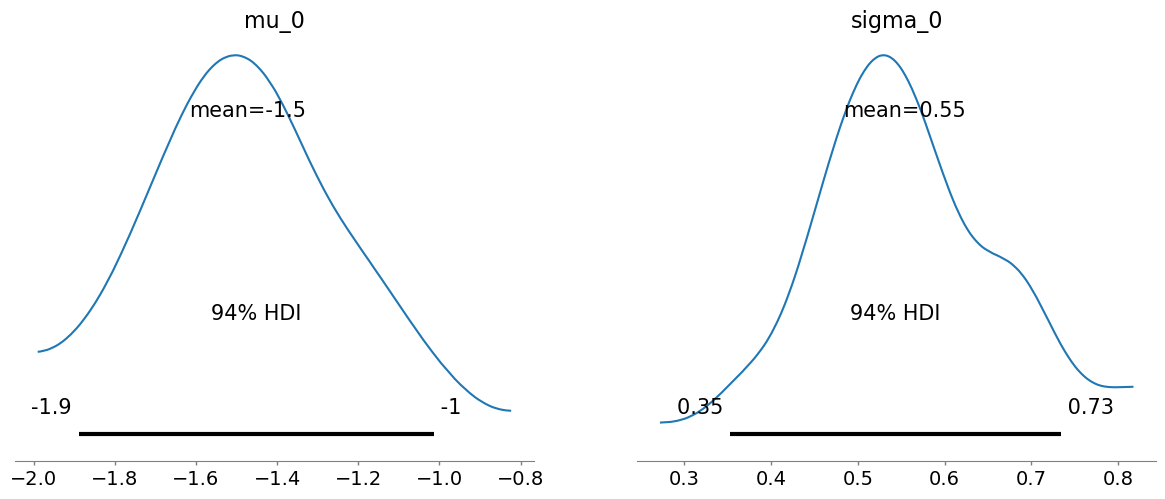

In [46]:
# use arviz to plot posterior as above
az.plot_posterior(trace, var_names=['mu_0', 'sigma_0'], round_to=2)

The range of the 94% HDI is large for $\mu_0$, suggesting that the true mean varies across districts in addition to the extreme values, maximum and minimum base rate of contraceptive usage, output in the previous question. Further, the mean and HDI of $sigma_0$ deviates from 0, suggesting that the true value of sigma is not 0, indicating that a varying intercept model is more appropriate than a model that pools all districts, ignoring the group-district effect.


<a id="part3"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

## <div class='exercise'>Part 3: Varying-Coefficient Model</div> 

[Return to contents](#contents)


The next model we will fit to the contraceptives data is a **varying-coefficients logistic regression** model. Here, in addition to a varying intercept, the coefficients on `living.children`, `age_mean`, and `urban` also vary by district.

Prior distribution:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_{1j} &\sim N(0,\sigma_1^2)\; \text{, with} \;\; \frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1) 
\\
\beta_{2j} &\sim N(0,\sigma_2^2)\; \text{, with} \;\; \frac{1}{\sigma^2_2} \sim \text{Gamma}(0.1,0.1)
\\ 
\beta_{3j} &\sim N(0,\sigma_3^2)\; \text{, with} \;\; \frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)
\\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} &\sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}
\\ \\
\end{split}
$$

**PLEASE NOTE:**

* The name "varying coefficient model" is used here to distinguish the Q3 model from the "varying intercept" model in Q2, but observe from the specification about that **BOTH** intercepts *and* coefficients vary in this Q3 model.
* Once again, the $\text{Gamma}$ distribution uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate. 

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.1 - Fit Varying Coefficient Model</b></div>

Fit the varying-coefficients model described above to the real training data.

In [57]:
# redo this (to not have to rerun above chains)

# district_idx, districts = pd.factorize(df_train['district'])
# n_districts = len(districts)

X1 = df_train['urban'].values
X2 = df_train['living.children'].values
X3 = df_train['age_mean'].values

In [ ]:
# create sigma 1,2,3 using specified Gamma dist above
sigma_1 = np.sqrt(1/(np.random.gamma(0.1, 0.1, n_districts)))
sigma_2 = np.sqrt(1/(np.random.gamma(0.1, 0.1, n_districts)))
sigma_3 = np.sqrt(1/(np.random.gamma(0.1, 0.1, n_districts)))

# varying coefficient model
with pm.Model() as coef_model:

    mu_0 = pm.Normal('mu_0', mu=0., sigma=1.0) 
    sigma_0 = pm.HalfNormal('sigma_0', sigma=1.0)  
    beta0 = pm.Normal('beta0', mu=mu_0, sigma=sigma_0, shape=n_districts)
    
    # vary slopes for each district this time using specified sigmas
    beta1 = pm.Normal('beta1', mu=0., sigma=sigma_1, shape=n_districts)
    beta2 = pm.Normal('beta2', mu=0., sigma=sigma_2, shape=n_districts)
    beta3 = pm.Normal('beta3', mu=0., sigma=sigma_3, shape=n_districts)
    
    #  predictor same as above, but index varying coefficients by district
    eta = beta0[district_idx] + beta1[district_idx]*X1 + beta2[district_idx]*X2 + beta3[district_idx]*X3
    
    p = pm.Deterministic('p', pm.math.sigmoid(eta))
    y = pm.Bernoulli('contraceptive_use', p, observed=df_train['contraceptive_use'])
    coef_trace = pm.sample(50, tune=50, target_accept=0.95, cores=2)

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_0, sigma_0, beta0, beta1, beta2, beta3]


Output()

Sampling 2 chains for 50 tune and 50 draw iterations (100 + 100 draws total) took 3630 seconds.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.2 - Convergence Diagnostics</b></div>

Check the convergence of your varying-coefficients model by examining the trace plots and R-hats, as you did with the varying-intercept models earlier. What do you observe?

In [59]:
# your code here
summary = pm.summary(coef_trace, var_names=['mu_0', 'sigma_0', 'beta1', 'beta2', 'beta3'])
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_0,-1.800,0.369,-2.511,-1.322,0.076,0.055,22.0,33.0,1.06
sigma_0,1.043,0.620,0.212,2.256,0.377,0.303,3.0,17.0,2.31
beta1[0],0.726,0.842,-0.827,2.357,0.092,0.097,84.0,78.0,1.14
beta1[1],2.100,6.152,-7.655,11.282,2.576,1.924,6.0,28.0,1.32
beta1[2],2.495,1.897,-1.027,5.417,0.507,0.367,14.0,49.0,1.11
...,...,...,...,...,...,...,...,...,...
beta3[55],0.078,0.129,-0.149,0.333,0.012,0.010,118.0,52.0,1.05
beta3[56],20.737,6.183,12.138,34.836,2.574,1.921,6.0,13.0,1.31
beta3[57],0.035,0.129,-0.232,0.217,0.017,0.012,51.0,77.0,1.03
beta3[58],0.084,0.177,-0.159,0.461,0.019,0.017,99.0,78.0,1.02


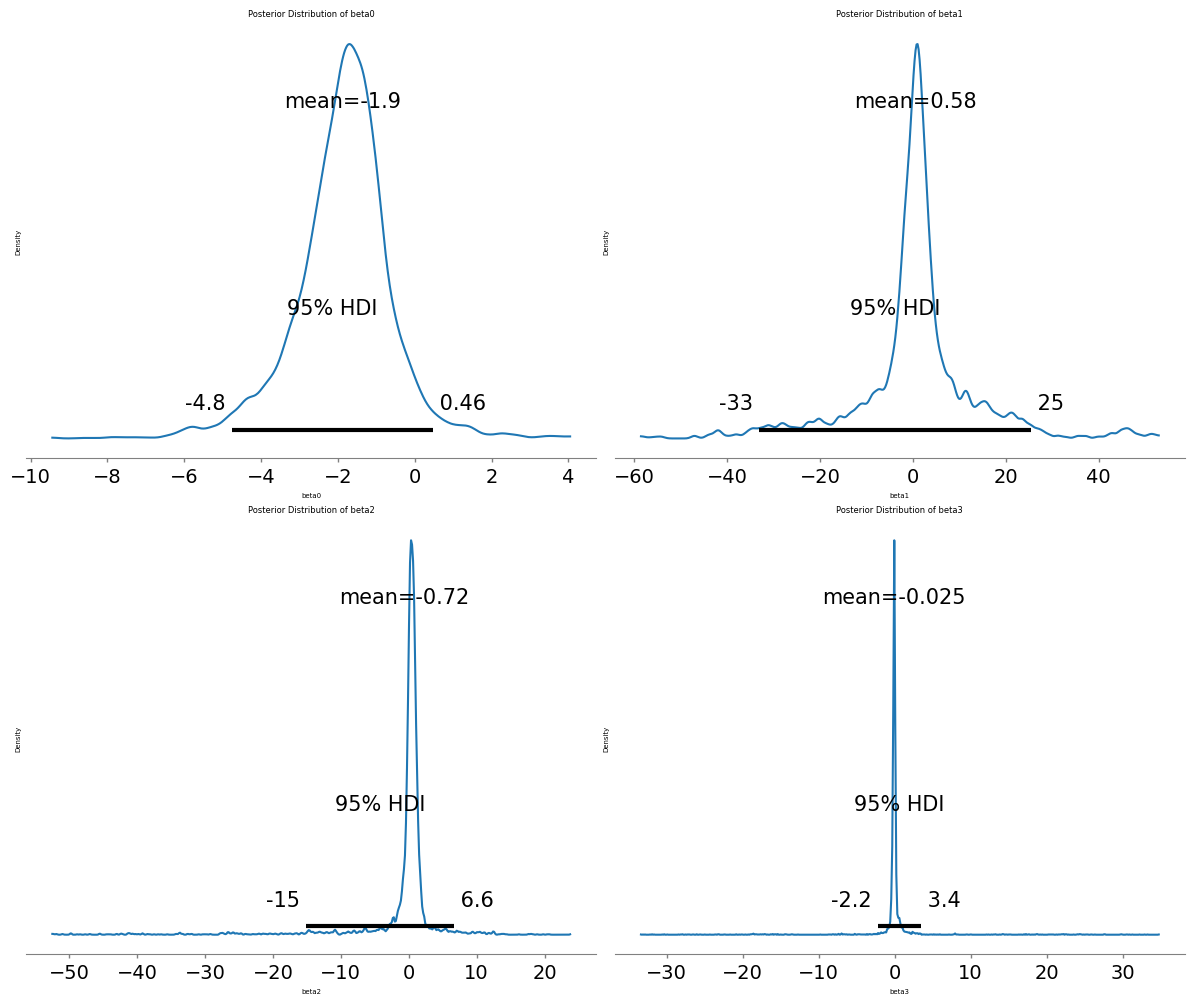

In [60]:
# put betas into separate arrays
beta0_samples = coef_trace.posterior['beta0'].values.flatten()
beta1_samples = coef_trace.posterior['beta1'].values.flatten()
beta2_samples = coef_trace.posterior['beta2'].values.flatten()
beta3_samples = coef_trace.posterior['beta3'].values.flatten()

#az.plot_posterior(trace, var_names=['mu_0', 'sigma_0', 'beta1', 'beta2', 'beta3'], round_to=2
# plot 4 separate posterior plots for each beta
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

az.plot_posterior(beta0_samples, ax=axes[0, 0], round_to=2, hdi_prob=0.95)
axes[0, 0].set_title('Posterior Distribution of beta0')
axes[0, 0].set_xlabel('beta0')
axes[0, 0].set_ylabel('Density')

az.plot_posterior(beta1_samples, ax=axes[0, 1], round_to=2, hdi_prob=0.95)
axes[0, 1].set_title('Posterior Distribution of beta1')
axes[0, 1].set_xlabel('beta1')
axes[0, 1].set_ylabel('Density')

az.plot_posterior(beta2_samples, ax=axes[1, 0], round_to=2, hdi_prob=0.95)
axes[1, 0].set_title('Posterior Distribution of beta2')
axes[1, 0].set_xlabel('beta2')
axes[1, 0].set_ylabel('Density')

az.plot_posterior(beta3_samples, ax=axes[1, 1], round_to=2, hdi_prob=0.95)
axes[1, 1].set_title('Posterior Distribution of beta3')
axes[1, 1].set_xlabel('beta3')
axes[1, 1].set_ylabel('Density')

plt.tight_layout()
plt.show()

Some of the r-hats output above deviate significantly from 1, suggesting that convergence issues exist. The trace plots do not show well-mixed chains with good convergence, reflecting the many divergences output during runtime above. Additionally, the large 95% HDI output for each $\beta$ in the posterior density plots represents an extremely large range, all including 0, suggesting convergence issues and large uncertainty within the variation of the model. These problems could be addressed with a larger ```target_accept``` and longer chains/burn in time.


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.3 - Distribution of Posterior Means & HDIs</b></div>

Plot the distributions of posterior means and the 95% highest posterior density intervals (HDIs) for the intercepts and coefficients for each district. What do you conclude from these graphs?

**HINT:** The ArviZ [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) function is very well-suited for this task.

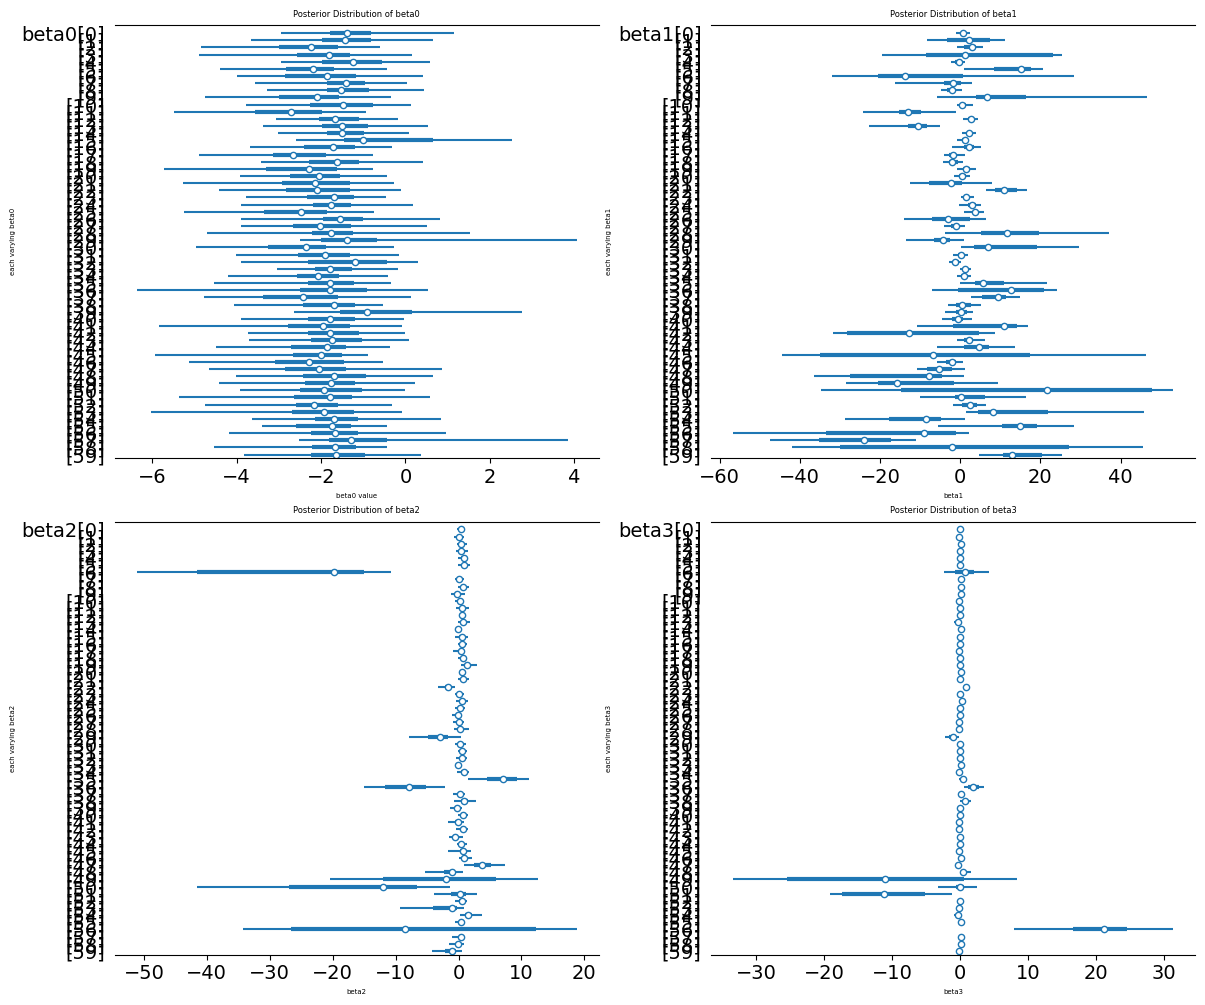

In [61]:
#az.plot_forest(trace, var_names=['beta1', 'beta2', 'beta3'], combined=True)
# plot each of the beta_samples
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

az.plot_forest(coef_trace, var_names=['beta0'], ax=axes[0, 0], combined=True, hdi_prob=0.95)
axes[0, 0].set_title('Posterior Distribution of beta0')
axes[0, 0].set_xlabel('beta0 value')
axes[0, 0].set_ylabel('each varying beta0')

az.plot_forest(coef_trace, var_names='beta1', ax=axes[0, 1], combined=True, hdi_prob=0.95)
axes[0, 1].set_title('Posterior Distribution of beta1')
axes[0, 1].set_xlabel('beta1')
axes[0, 1].set_ylabel('each varying beta1')

az.plot_forest(coef_trace, var_names='beta2', ax=axes[1, 0], combined=True, hdi_prob=0.95)
axes[1, 0].set_title('Posterior Distribution of beta2')
axes[1, 0].set_xlabel('beta2')
axes[1, 0].set_ylabel('each varying beta2')

az.plot_forest(coef_trace, var_names='beta3', ax=axes[1, 1], combined=True, hdi_prob=0.95)
axes[1, 1].set_title('Posterior Distribution of beta3')
axes[1, 1].set_xlabel('beta3')
axes[1, 1].set_ylabel('each varying beta3')

plt.tight_layout()
plt.show()

The varying intercepts visually seem to deviate more than they did in question 2, where the intercept was varying and the coeficients were held constant. That being said, the mean log-odds value seems to be lower and closer to the mininimum of that in the question 2 varying-intercept model. This is likely due to the influence of the varying coeficients. $\beta_1$, urban population, seems to be the only predictor that significantly deviates from 0. However, there looks to be a large amount of uncertainty around the positive or negative effect of urban population on probability of contraceptive use. Lastly, the distributions of number of living children and age suggest that these coeficients have an insignificant and uncertain influence on the response variable due to most districts having a near-zero coeficient value with a small range.  

<a id="part4"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

## <div class='exercise'>Part 4: Predictions & Model Selection</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.1 - Model Evaluation & Comparison</b></div>

Now that we’ve fit varying-intercept and varying-coefficient models we will evaluate their predictive performance and compare them to a naive baseline.
 
First, sample from the posterior predictive distribution using `pm.sample_posterior_predictive()`, generating predictions for both models on the train and test sets.

Next, compute the accuracy and percentage of predictions classified as `1` for each model on both train and test.

Finally, compute the train and test accuracy of a naive model that predicts the most common class in the training set for all inputs.

In [ ]:
# sample posterior predictive distributions for varying-intercept and varying-coef
with actual_model:
	posterior_predictive = pm.sample_posterior_predictive(trace)

# compute accuracy, percentage of predictions that are 1 
predictions = posterior_predictive.posterior_predictive['contraceptive_use'].values
y_true = df_train['contraceptive_use'].values

predictions = predictions.mean(axis=0).round().astype(int) #round means to 0 or 1 to represent prediced labels
accuracy = np.mean(predictions == y_true)
print(f"Train Accuracy for Varying Intercept Model: {accuracy:.3f}")
print(f"percentage of predictions that are 1: {predictions.mean():.3f}")


Sampling: [contraceptive_use]


Output()

Train Accuracy for Varying Intercept Model: 0.617
percentage of predictions that are 1: 0.200


In [ ]:
# compute accuracy, percentage for test set
# speficy var_names = p to use already model parameters on the new predictor values (test) rather than training data
with actual_model:
    posterior_predictive_test = pm.sample_posterior_predictive(trace, var_names=['p'])

# get posterior predictive on the test data
predictions_test = posterior_predictive_test.posterior_predictive['p'].values
y_true_test = df_test['contraceptive_use'].values

predictions_test = predictions_test.mean(axis=0).round().astype(int)
accuracy_test = np.mean(predictions_test == y_true_test)
print(f"Test Accuracy for Varying Intercept Model: {accuracy_test:.3f}")
print(f"percentage of predictions that are 1: {predictions_test.mean():.3f}")

Sampling: []


Output()

Test Accuracy for Varying Intercept Model: 0.548
percentage of predictions that are 1: 0.231


In [64]:
# same procedure for varying-coef model
with coef_model:
    posterior_predictive_coef = pm.sample_posterior_predictive(coef_trace)

predictions_coef = posterior_predictive_coef.posterior_predictive['contraceptive_use'].values
y_true_coef = df_train['contraceptive_use'].values

predictions_coef = predictions_coef.mean(axis=0).round().astype(int)
accuracy_coef = np.mean(predictions_coef == y_true_coef)
print(f"Train Accuracy for Varying Coef Model: {accuracy_coef:.3f}")
print(f"percentage of predictions that are 1: {predictions_coef.mean():.3f}")

with coef_model:
    posterior_predictive_coef_test = pm.sample_posterior_predictive(coef_trace, var_names=['p'])

predictions_coef_test = posterior_predictive_coef_test.posterior_predictive['p'].values
y_true_coef_test = df_test['contraceptive_use'].values

predictions_coef_test = predictions_coef_test.mean(axis=0).round().astype(int)
accuracy_coef_test = np.mean(predictions_coef_test == y_true_coef_test)
print(f"Test Accuracy for Varying Coef Model: {accuracy_coef_test:.3f}")
print(f"percentage of predictions that are 1: {predictions_coef_test.mean():.3f}")

Sampling: [contraceptive_use]


Output()

Sampling: []


Output()

Train Accuracy for Varying Coef Model: 0.671
percentage of predictions that are 1: 0.216


Test Accuracy for Varying Coef Model: 0.527
percentage of predictions that are 1: 0.355


In [65]:
# create naive model (predicts 1,0 depending on training data mode)
naive_accuracy = df_train['contraceptive_use'].mean()
print(f"Naive Model Train Accuracy: {max(1 - naive_accuracy, naive_accuracy):.3f}")
print(f"percentage of naive model predictions that are 1: {naive_accuracy:.3f}")

naive_accuracy_test = df_test['contraceptive_use'].mean()
print(f"Naive Model Test Accuracy: {max(1 - naive_accuracy_test, naive_accuracy_test):.3f}")
print(f"percentage of naive model predictions that are 1: {naive_accuracy_test:.3f}")

Naive Model Train Accuracy: 0.610
percentage of naive model predictions that are 1: 0.390
Naive Model Test Accuracy: 0.605
percentage of naive model predictions that are 1: 0.395


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.2 - Model Selection</b></div>

What do you conclude from the results of 4.1? Which model appears to be the best (i.e. varying-intercept, varying-coefficient, or naive), and what is your rationale?

The best model appears to be naive. Firstly, my rationale for excluding the varying-coefficient model lies mainly in question 3, where ```plot_forest``` and posterior distribution plots suggested that varying-coefficients introduce unnecessary variation to the model. In addition, the test accuracy for the varying coefficient model was the worst even though it had the highest training accuracy, further suggesting that this model is too complex. Secondly, the varying-intercept model exhibited well-mixed chains and good converenge according to the trace plots, posterior distribution plots, and r-hat scores. However, the model still had a lower test accuracy than the naive model, suggesting overfitting. Although the best model is naive based on the test accuracy, techniques like regularization could enhance the varying-coefficient model's ability to generalize to the test data.


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.3 Wrap-up</b></div>

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `time_spent_on_hw`

In [ ]:
time_spent_on_hw = 11

*Your answer here*



In [65]:
grader.check("q4.3")

q4.3 results:
    q4.3 - 1 result:
        ❌ Test case failed
        Trying:
            assert float(time_spent_on_hw), 'Please select a time in hours (int or float) to specify how long you spent on this assignment.'
        Expecting nothing
        **********************************************************************
        Line 1, in q4.3 0
        Failed example:
            assert float(time_spent_on_hw), 'Please select a time in hours (int or float) to specify how long you spent on this assignment.'
        Exception raised:
            Traceback (most recent call last):
              File "c:\Users\khcod\micromamba\envs\cs109a\Lib\doctest.py", line 1368, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q4.3 0[0]>", line 1, in <module>
                assert float(time_spent_on_hw), 'Please select a time in hours (int or float) to specify how long you spent on this assignment.'
                             ^^^^^^^^^^^^^^^^
            NameError: name 'time_spent_on_hw' is not defined

In [ ]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

**This concludes HW1. Thank you!** 🌈